In [1]:
%load_ext autoreload
%autoreload 2

# NOTES

- [Compound Clustering Tutorial](https://projects.volkamerlab.org/teachopencadd/talktorials/T005_compound_clustering.html)
- [Topic Modeling with BERT](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)
- [sentence-transforrmers clustering](https://www.sbert.net/examples/applications/clustering/README.html)
  - [fast_clustering](https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/clustering/fast_clustering.py)
    - 50k sentences in less than 5 seconds).
    - In a large list of sentences it searches for local communities: A local community is a set of highly similar sentences.


In [2]:
import pandas as pd
from thesis_work.utils import get_largest_fragment_from_smiles
from thesis_work.chemberta.model_descriptors import (
    gen_embeddings,
    initialize_model_tokenizer,
    get_model_descriptors as get_model_descriptors_chemberta,
)
from thesis_work.utils import get_ecfp_descriptor
from thesis_work.data import load_data, load_mixed_interacted_compounds

import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import DataStructs
from sklearn.metrics import silhouette_score
import numpy as np
from thesis_work.clustering import get_efcp_similarity_matrix, get_efcp_distance_matrix
import logging
from thesis_work.clustering import apply_k_means, apply_umap, plot_umap
from thesis_work.chemprop.model_descriptors import (
    get_model_descriptors as get_model_descriptors_chemprop,
)
import os
import wandb

os.environ["WANDB_NOTEBOOK_NAME"] = "./clustering.ipynb"

wandb.login()


# Silence RDKit warnings
# logger = RDLogger.logger()
# logger.setLevel(RDLogger.CRITICAL)

# Silence transformers warnings
# logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
# from transformers import logging
# logging.set_verbosity_error()


## print numpy array more beautifully
# np.set_printoptions(suppress=True)
# np.set_printoptions(precision=3)

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/ilker/miniconda3/envs/thesis-work/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
wandb: Currently logged in as: ilkersigirci. Use `wandb login --relogin` to force relogin


True

# Config Parameters


In [3]:
project_name = "Cluster-Experiments"

random_state = 42
device = "cuda"
# device  = "cpu"

In [4]:
run = wandb.init(
    project=project_name,
    config={
        "random_state": random_state,
        "device": device,
    },
)

## Data


### Ours


In [4]:
protein_type = "kinase"
# protein_type = "protease"
# protein_type = "gpcr"

wandb.config.update({"protein_type": protein_type})

data = load_data(protein_type=protein_type)
wandb.config.update({"dataset_size": data.shape[0]})

smiles = data["text"].tolist()
data

,text,labels
0,O=C(Cc1cccc2ccccc12)Nc1n[nH]c2ccc(N3CCCS3(=O)=...,1
1,COC(=O)NC[C@@H](NC(=O)c1ccc(-c2nc(C3CCOCC3)cnc...,1
2,COc1ccccc1Nc1cc(Oc2cc(C)c(C)nc2-c2ccccn2)ccn1,1
3,O=C(/C=C/CN1CCCC1)N1CCOc2cc3ncnc(Nc4ccc(F)c(Cl...,1
4,O=C(Nc1cccc(Nc2cc3c(=O)[nH][nH]c(=O)c3cc2Cl)c1...,1
...,...,...
66304,CS(=O)(=O)c1ccccc1Nc1cccn2nc(Nc3ccc(OCCN4CCCC4...,0
66305,CC(C)n1cc(C(=O)c2cncc(NC(=O)c3ccc4nnnn4c3)c2)c...,0
66306,CNC(=O)c1ccc2[nH]nc(-c3cccc(C(=O)NCc4cccc5cccc...,0
66307,NC(=O)c1c(NC(=O)COC(=O)CCC(=O)c2ccc(Cl)cc2)sc2...,0


### Ours - Mixed Interactive


In [5]:
each_sample_size = 2000
protein_types = ["gpcr", "kinase", "protease"]
protein_types.sort()
protein_labels = [x for x in range(len(protein_types))]

wandb.config.update({"protein_types": protein_types})

data = load_mixed_interacted_compounds(
    protein_types=protein_types,
    each_sample_size=each_sample_size,
    random_state=random_state,
    convert_category=True,
)
wandb.config.update({"dataset_size": data.shape[0]})

smiles = data["text"].tolist()
data

,text,labels
0,O=C(O)c1ccc(CN(CCc2ccccc2)C(=O)c2ccc(Oc3ccccc3...,0
1,CCc1sc(CCc2cc(OC3CCCCC3)cc(NCc3cc(Cl)cc(NC(=O)...,0
2,COc1cc(OC2CCN(Cc3ccc[n+]([O-])c3C(F)(F)F)CC2)c...,0
3,CCN(c1nc(C)cc(C)n1)c1c(Br)cc(C(C)C)cc1OC,0
4,CCCCCCC(C)(C)c1cc(O)c2c(c1)OC(C)(C)c1cn[nH]c1-2,0
...,...,...
5995,Nc1nc(Cn2c(-c3ccc(Oc4cncnc4)cc3)ccc2-c2ccccc2C...,2
5996,CC(C)(C)OC(=O)CCCCCCCCCCCNC(=O)NC12CC3CC(CC(C3...,2
5997,CSc1sc(C(=N)N)cc1S(=O)(=O)c1cc(Br)c2c(c1)ncn2C...,2
5998,COc1ccc(NC(=O)C2CCN(C(=O)N[C@@H](CC(=O)NCC(C)(...,2


### BBBP


In [5]:
# Read in data from MoleculeNet
data = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv")

# Clean up columnn names so they are easier to interpret
data = (
    data[["smiles", "p_np", "name"]]
    .reset_index(drop=True)
    .rename({"smiles": "text", "p_np": "labels"}, axis=1)
)

# Remove extra fragments in SMILES (typically salts, which are irrelevant to BBB permeability)
data["text"] = data["text"].apply(get_largest_fragment_from_smiles).dropna().astype(str)
wandb.config.update({"dataset_size": data.shape[0]})

# convert to str list
smiles = data["text"].tolist()

data

,text,labels,name
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin
...,...,...,...
2045,O=c1[nH]c2cc(Cl)c(Cl)c([N+](=O)[O-])c2[nH]c1=O,1,licostinel
2046,C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc...,1,ademetionine(adenosyl-methionine)
2047,CC(Cc1ccccc1)n1cc([N-]C(=O)Nc2ccccc2)[o+]n1,1,mesocarb
2048,CCc1c(C)[n+]([NH-])c(-c2ccc(OC)c(OC)c2)c2cc(OC...,1,tofisoline


### BCE - TODO


## Embeddings


### Chemberta


In [6]:
model_name = "DeepChem/ChemBERTa-77M-MTR"
# model_name = "DeepChem/ChemBERTa-77M-MLM"

wandb.config.update({"model_name": model_name})

vector_embeddings = pd.DataFrame(
    get_model_descriptors_chemberta(
        smiles_series=data["text"],
        model_name=model_name,
        method="simpletransformers",
    )
)

# data["vector"] = pd.DataFrame(get_model_descriptors(
#     smiles_series=data["text"],
#     model_name=model_name,
#     method="simpletransformers",
# )).tolist()

# data[[f"vector_{i}" for i in range(1, embedding_size+1)]] = pd.DataFrame(data["vector"])

vector_embeddings.shape

(6000, 384)

In [ ]:
### bert_loves_chemistry version

# model, tokenizer = initialize_model_tokenizer(model_name=model_name)
# vector_embeddings = gen_embeddings(model=model, tokenizer=tokenizer, smiles=smiles)
# vector_embeddings.shape

### Chemprop


In [6]:
model_name = "chemprop"
wandb.config.update({"model_name": model_name})

vector_embeddings = pd.DataFrame(
    get_model_descriptors_chemprop(smiles_series=data["text"])
)

vector_embeddings.shape

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Moving model to cuda


100%|██████████| 6000/6000 [00:02<00:00, 2889.57it/s]


(6000, 25)

### ECFP

- ECFP4 - 1024
- ECFP6 - 2048


In [6]:
model_name = "ecfp"
radius = 2
nBits = 2048

wandb.config.update({"model_name": model_name, "radius": radius, "nBits": nBits})

# Generate ECFP descriptors
ecfp_vectors = [
    get_ecfp_descriptor(
        smiles_str=smiles_str, radius=radius, nBits=nBits, return_type="np_array"
    )
    for smiles_str in smiles
]
vector_embeddings = np.array(ecfp_vectors)
# n_ecfps = ecfp_vectors.shape[0]

vector_embeddings.shape

(6000, 2048)

## Dimensionality Reduction


In [7]:
n_components = 20
n_neighbors = 15
min_dist = 0.1
metric = "euclidean"


wandb.config.update(
    {
        "dim_reduction": "UMAP",
        "n_components": n_components,
        "n_neighbors": n_neighbors,
        "min_dist": min_dist,
        "metric": metric,
    }
)


vector_embeddings = apply_umap(
    data=vector_embeddings,
    n_components=n_components,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    metric=metric,
    random_state=random_state,
    device=device,
)

## K-Means

### NOTE

- No need for k-means, but needs for butina.
- Actually, when finding similary compounds in k-means, we might use Tanimoto similarity,
  but noone seem to do so. WHY ??
- [practicalcheminformatics Guide](https://practicalcheminformatics.blogspot.com/2019/01/k-means-clustering.html)

### ECFP4 - 2048

- CPU: 2.0s
- GPU: 1.8s
- Silhouette score: 0.014231271668859027

#### With UMAP

- 20 features
  - Silhouette score: 0.743

### Chemberta Model Embeddings

- Silhouette score: 0.4123
- CPU: 1.3s for (6000, 384)
- GPU: 1.5s for (6000, 384)

#### With UMAP

- 20 features
  - Silhouette score: 0.525

### Chemprop Model Embeddings

- Silhouette score: 0.24
- CPU: ?
- GPU: ?


In [ ]:
# similarity_matrix = get_efcp_similarity_matrix(smiles_list=smiles, method="fast")

## For checking the slow method
# similarity_matrix_slow = get_efcp_similarity_matrix(smiles_list=smiles, method="slow")
# np.array_equal(similarity_matrix, similarity_matrix_slow)
# np.allclose(similarity_matrix, similarity_matrix_slow, rtol=0, atol=0.2)

In [8]:
wandb.config.update({"clustering_method": "K-MEANS"})

cluster_range = 20
scores = []
inertias = []


for i in range(2, cluster_range):
    # i = 3

    cluster_labels, inertia = apply_k_means(
        data=vector_embeddings,
        init_method="k-means++",
        n_clusters=i,
        random_state=random_state,
        n_init=1,
        device=device,
    )

    inertias.append(inertia)

    score = silhouette_score(vector_embeddings, cluster_labels)
    scores.append(score)

    wandb.log({"silhouette_score": score, "inertia": inertia})
    # print(f"Cluster: {i}, Silhouette score: {score:.3f}")

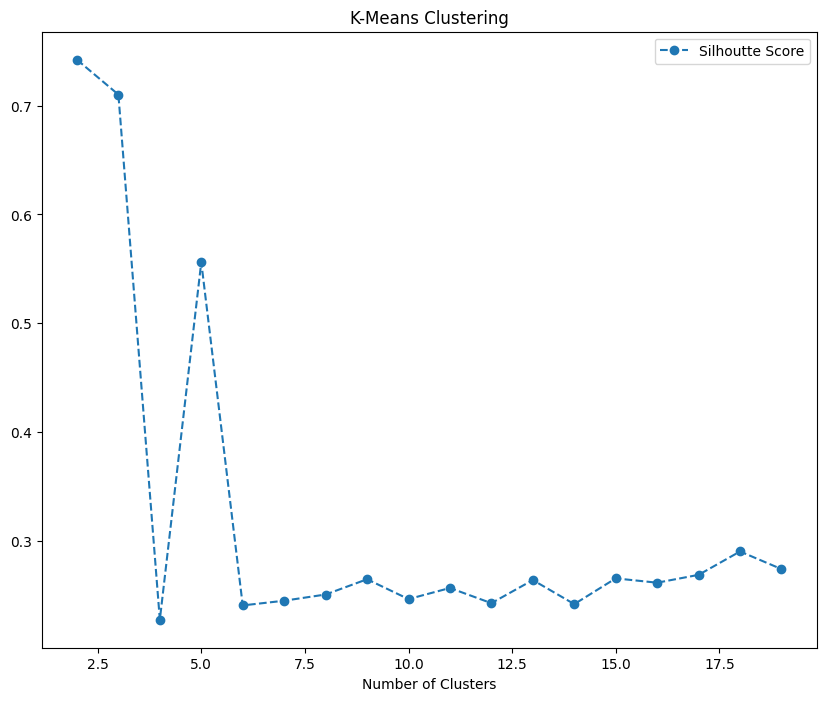

In [9]:
# for cluster_id in range(num_clusters):
#     print(f"Cluster {cluster_id + 1}:")
#     cluster_text_indices = np.where(cluster_labels == cluster_id)[0]
#     for index in cluster_text_indices:
#         print(smiles[index])
#     print("\n")

plt.figure(figsize=(10, 8))
# plt.plot(range(2, len(inertias)+2), inertias, marker='o', linestyle='--', label='Inertia')
plt.plot(
    range(2, len(inertias) + 2),
    scores,
    marker="o",
    linestyle="--",
    label="Silhoutte Score",
)
plt.legend()
plt.xlabel("Number of Clusters")
# plt.ylabel('Inertia Scores')
plt.title("K-Means Clustering")
plt.show()

## Butina clustering

- Silhouette Score:

  - 0.2 Threshold: 0.0007162032683292052 ??

- The higher the threshold (distance cutoff), the more molecules are considered as similar and, therefore, clustered into less clusters. The lower the threshold, the more small clusters and “singletons” appear.


In [7]:
# threshold = 0.2
# threshold = 0.4
# threshold = 0.6
threshold = 0.8

In [ ]:
from rdkit.ML.Cluster import Butina

distances = get_efcp_distance_matrix(smiles_list=smiles, method="fast")

clusters = Butina.ClusterData(distances, n_ecfps, threshold, isDistData=True)
clusters = sorted(clusters, key=len, reverse=True)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

In [ ]:
# Plot the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)

In [ ]:
# Convert the clusters into labels for the silhouette score
cluster_labels = np.zeros(n_ecfps)
for i, cluster in enumerate(clusters):
    for mol in cluster:
        cluster_labels[mol] = i


# Compute the silhouette score
silhouette_score = silhouette_score(
    distances.tolist(), cluster_labels, metric="jaccard"
)
# silhouette_score = silhouette_score(ecfps, cluster_labels, metric="jaccard")

print("Silhouette Score: ", silhouette_score)
print("Cluster assignments: ", cluster_labels)

## QPI


In [ ]:
# FIXME: Not working
def quality_partition_index(clusters, distances):
    intra_cluster_distances = [
        min([distances[i][j] for j in cluster]) for i, cluster in enumerate(clusters)
    ]
    min_intra_cluster_distance = min(intra_cluster_distances)
    max_inter_cluster_distance = max(
        [distances[i][j] for i in range(len(distances)) for j in range(i)]
    )

    return min_intra_cluster_distance / max_inter_cluster_distance


qpi = quality_partition_index(clusters, distances)
print("Quality Partition Index: ", qpi)

# END WANDB


In [10]:
if wandb.run is not None:
    wandb.finish()

inertia,█▇▆▇▅▅▄▃▂▂▂▂▁▁▁▁▁▁
silhouette_score,██▁▅▁▁▁▂▁▁▁▁▁▂▁▂▂▂
inertia,10633.25977
silhouette_score,0.27417
